# Import Dependencies

We begin by importing the necessary libraries.

In [1]:
# Data analysis
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
sns.set()

# Preprocessing

Next, read in the relevant shapefiles, starting with the Malaysian state & federal territories data.

In [2]:
# Load Malaysia state map into GeoDataFrame
msia_states = gpd.read_file('../data/malaysia/states/MYS_adm1.shp')

# Fix typos
msia_states['NAME_1'] = msia_states['NAME_1'].replace('Trengganu', 'Terengganu')

# Display first 5 rows
msia_states.head()

ID_0  ISO    NAME_0  ID_1        NAME_1 HASC_1  CCN_1  CCA_1  \
0   136  MYS  Malaysia     1         Johor  MY.JH      0    NaN   
1   136  MYS  Malaysia     2         Kedah  MY.KH      0    NaN   
2   136  MYS  Malaysia     3      Kelantan  MY.KN      0    NaN   
3   136  MYS  Malaysia     4  Kuala Lumpur  MY.KL      0    NaN   
4   136  MYS  Malaysia     5        Labuan  MY.LA      0    NaN   

                TYPE_1          ENGTYPE_1  NL_NAME_1  \
0               Negeri              State        NaN   
1               Negeri              State        NaN   
2               Negeri              State        NaN   
3  Wilayah Persekutuan  Federal Territory        NaN   
4  Wilayah Persekutuan  Federal Territory        NaN   

                           VARNAME_1  \
0          Johor Darul Takzim|Johore   
1                   Kedah Darul Aman   
2                                NaN   
3  Federal Territory of Kuala Lumpur   
4        Federal Territory of Labuan   

                                            geometry  
0  MULTIPOLYGON (((103.42134 1.30583, 103.42113 1...  
1  MULTIPOLYGON (((100.32889 5.66444, 100.32917 5...  
2  MULTIPOLYGON (((102.17395 6.20126, 102.17395 6...  
3  POLYGON ((101.73227 3.03781, 101.70284 3.03007...  
4  MULTIPOLYGON (((115.25285 5.38809, 115.25571 5...

We can visualize these data to make sure everything is in order.

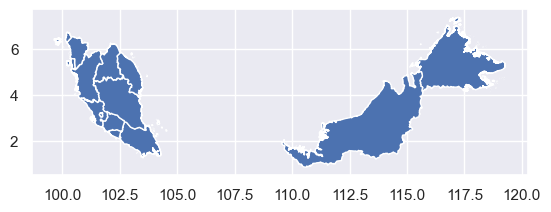

In [3]:
# Visualize GeoDF
msia_states.plot()
plt.show()

Indeed, no issues of note. Also load in the 2022 general election (hereafter: GE-15) data.

In [4]:
# Load Malaysia GE-15 results
msia_ge15 = pd.read_csv('../data/malaysia/ge15/combined_results_parliament_ge15.csv')

# Fix typos
msia_ge15['state'] = msia_ge15['state'].replace('KL', 'Kuala Lumpur')
msia_ge15['state'] = msia_ge15['state'].replace('Penang', 'Pulau Pinang')

# Display first 5 rows
msia_ge15.head()

Unnamed: 0  year                  name coalition party_code  votes  \
0         641  2022         RUSYDAN RUSMI        PN        PAS  24267   
1         644  2022     ZAHIDA ZARIK KHAN        BN       UMNO  11753   
2         645  2022  MOHAMAD SAAD @ YAHYA        PH     AMANAH   7085   
3         643  2022  ZAHIDI ZAINUL ABIDIN       NaN        IND   1939   
4         642  2022          KO CHU LIANG       NaN    WARISAN    244   

   vote_share  parliament_code_digits  constituency   state  total_votes  \
0   53.583731                       1  PADANG BESAR  Perlis        45288   
1   25.951687                       1  PADANG BESAR  Perlis        45288   
2   15.644321                       1  PADANG BESAR  Perlis        45288   
3    4.281487                       1  PADANG BESAR  Perlis        45288   
4    0.538774                       1  PADANG BESAR  Perlis        45288   

  gender  results_added  spr_id  winner  
0      F              1  1069.0     1.0  
1      M              1   259.0     0.0  
2      F              1   118.0     0.0  
3      F              1  1113.0     0.0  
4      F              1   969.0     0.0

Merge the dataframes along the state column; rename and reorder the columns where appropriate. 

In [5]:
# Merge dataframes by state
df = msia_states.merge(msia_ge15, left_on='NAME_1', right_on='state')

# Drop unnecessary columns
df = df[['ID_1', 'ENGTYPE_1', 'VARNAME_1', 'geometry', 'year', 
         'name', 'coalition', 'party_code', 'votes', 'vote_share', 
         'parliament_code_digits', 'constituency', 'state', 'total_votes', 'gender', 'winner']]

# Rename columns
df.rename(columns={
    'ID_1': 'state_id',
    'ENGTYPE_1': 'state_type',
    'VARNAME_1': 'state_alt_name',
    'name': 'candidate_name',
    'votes': 'votes_received',
    'gender': 'candidate_sex'
    }, inplace=True)

# Reorder columns
df = df[['state', 'state_id', 'state_type', 'state_alt_name', 'year', 
    'candidate_name', 'candidate_sex', 'coalition', 'party_code', 'constituency', 
    'parliament_code_digits', 'votes_received', 'vote_share', 'total_votes', 'winner', 'geometry']]

# Display first 5 rows
df.head()

state  state_id state_type             state_alt_name  year  \
0  Johor         1      State  Johor Darul Takzim|Johore  2022   
1  Johor         1      State  Johor Darul Takzim|Johore  2022   
2  Johor         1      State  Johor Darul Takzim|Johore  2022   
3  Johor         1      State  Johor Darul Takzim|Johore  2022   
4  Johor         1      State  Johor Darul Takzim|Johore  2022   

                 candidate_name candidate_sex coalition party_code  \
0            YUNESWARAN RAMARAJ             F        PH        PKR   
1            RAMASAMY MUTHUSAMY             F        BN        MIC   
2            POOBALAN PONNUSAMY             F        PN    BERSATU   
3  SYED HAIROUL FAIZEY SYED ALI             F       GTA      PUTRA   
4                ZALIHA MUSTAFA             M        PH        PKR   

  constituency  parliament_code_digits  votes_received  vote_share  \
0      SEGAMAT                     140           23437   46.270631   
1      SEGAMAT                     140           17768   35.078575   
2      SEGAMAT                     140            8385   16.554134   
3      SEGAMAT                     140            1062    2.096660   
4     SEKIJANG                     141           18941   39.266538   

   total_votes  winner                                           geometry  
0        50652     1.0  MULTIPOLYGON (((103.42134 1.30583, 103.42113 1...  
1        50652     0.0  MULTIPOLYGON (((103.42134 1.30583, 103.42113 1...  
2        50652     0.0  MULTIPOLYGON (((103.42134 1.30583, 103.42113 1...  
3        50652     0.0  MULTIPOLYGON (((103.42134 1.30583, 103.42113 1...  
4        48237     1.0  MULTIPOLYGON (((103.42134 1.30583, 103.42113 1...

Finally, create a separate dataframe containing the winning coalition in each state/federal territory. Note, a coalition is considered to be the winner in a state if they earn the most seats in that state; a seat is earned when `winner == 1`.

In [6]:
# Filter winning rows only
winning_rows = df[df['winner'] == 1]

# Group winning rows by state and coalition, then count the number of times each coalition won in each state
state_coalition_counts = winning_rows.groupby(['state', 'coalition'])['coalition'].count().reset_index(name='seats_won')

# For each state, find the coalition that won the most seats
winning_coalition = state_coalition_counts.loc[state_coalition_counts.groupby('state')['seats_won'].idxmax()].reset_index(drop=True)

# Calculate the percent of total seats won by the winning coalition
total_seats_by_state = df[df['winner'] == 1].groupby('state')['winner'].sum().astype('int').reset_index(name='total_seats')
winning_coalition = pd.merge(winning_coalition, total_seats_by_state, on='state')
winning_coalition['percent_of_total_seats_won'] = round(winning_coalition['seats_won'] / winning_coalition['total_seats'] * 100, 2)

# Display results
winning_coalition


state coalition  seats_won  total_seats  \
0             Johor        PH         15           26   
1             Kedah        PN         13           14   
2          Kelantan        PN         14           14   
3      Kuala Lumpur        PH         10           11   
4            Melaka        PH          3            6   
5   Negeri Sembilan        BN          5            8   
6            Pahang        PN          7           14   
7             Perak        PH         11           24   
8            Perlis        PN          3            3   
9      Pulau Pinang        PH         10           13   
10        Putrajaya        PN          1            1   
11            Sabah        BN          7           26   
12          Sarawak       GPS         22           30   
13         Selangor        PH         16           22   
14       Terengganu        PN          8            8   

    percent_of_total_seats_won  
0                        57.69  
1                        92.86  
2                       100.00  
3                        90.91  
4                        50.00  
5                        62.50  
6                        50.00  
7                        45.83  
8                       100.00  
9                        76.92  
10                      100.00  
11                       26.92  
12                       73.33  
13                       72.73  
14                      100.00

# Data Visualization

It remains to create an interactive election map to visualize the Malaysian GE-15 results, where coalitions are colored based on their official colors. We'll also include popups displaying key election information for each state/federal territory, such as the number of seats won and the percent of total seats won.

In [7]:
# Create a dictionary mapping coalitions to their respective colors
coalition_colors = {'BN': 'blue', 
                    'PH': 'red', 
                    'PN': 'lightblue',
                    'GPS': 'pink'}

# Generate interactive map object 
m = folium.Map(location=[4.2105, 108.9758], tiles='cartodbpositron', zoom_start=6)

# Loop through each state and add a colored polygon for each state's boundary
for index, row in winning_coalition.iterrows():
    state, coalition, = row['state'], row['coalition']
    color = coalition_colors.get(coalition, 'white')
    
    # Find the row in the original dataframe corresponding to the current state
    state_data = df[df['state'] == state]
    
    # Create the popup message
    popup_html = f"<b>{state}</b><br/><br/>Winner: {coalition}<br/>Seats: {row['seats_won']} (<u>{row['percent_of_total_seats_won']}%</u> of total seats)"
        
    # Create the polygon with appropriate customizations and add it to the map
    folium.GeoJson(state_data['geometry'].iloc[0], 
                   name=state, 
                   style_function=lambda x, color=color: {'fillColor': color, 
                                                          'fillOpacity': 0.7, 
                                                          'color': 'black', 
                                                          'weight': 1}, 
                   tooltip=state).add_to(m).add_child(folium.Popup(popup_html))

# Add a layer control to the map
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('../msia_ge_15_map.html')

# Display results
m

As we can see, the center-left coalition PH (Malay: Pakatan Harapan, English: Alliance of Hope; colored red) and center-right coalition PN (Malay: Perikatan Nasional, English: National Alliance; colored light blue) are tied for most victories at 6 states each. The usually formidable right-wing coalition BN (Malay: Barisan Nasional, English: National Front; colored blue) only managed to secure 2 states, likely due to the ongoing corruption investigations involving ex-party leaders. Finally, GPS (Malay: Gabungan Parti Sarawak, English: Sarawak Parties Alliance; colored light pink) have secured their stronghold state of Sarawak as usual, with a clear majority - 73.33% of total seats won in the state. 

Note the geographic trends in the GE-15 results, i.e. states along the West coast of the peninsula tend to be more left-leaning, while states along the East coast tend to favor center-right to right-wing parties. 